<a href="https://colab.research.google.com/github/Shashwat17-vit/Leaf-Vein-Segmentation-using-ResNet-UNet/blob/main/FreshTomatoResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Unet Implementation using Data Augmentation and Overfitting reduction approaches on small dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import skimage.io
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator



seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_pred = K.cast(y_pred, 'float32')  # Ensure y_pred is float32

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

#CLAHE
def clahe_equalized(imgs):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized


Define Load Images  

In [4]:

def load_images(image_dir, img_size=(1376, 864)):
    images = []
    image_files = sorted(os.listdir(image_dir))  # Ensure correct order

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, target_size=img_size)  # Resize
        img = img_to_array(img)  # Convert to array (H, W, 3)
        img_red_channel = img[:, :, 0]
        images.append(img_red_channel)

    return np.array(images, dtype=np.uint8)  # Ensure dtype is uint8


Loading Training Images

Loaded 17 images
Image shape: (1376, 864)
17


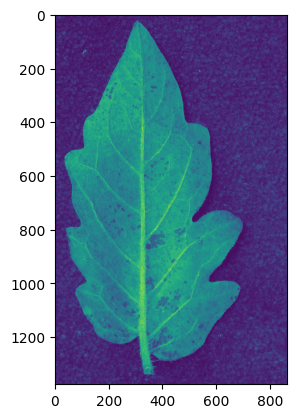

In [5]:
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train"
#image_dir = "infected-tomato-leaf-vein-segmentation/train"

img_size = (1376, 864)  # Input size for U-Net

images_kaggle = load_images(image_dir, img_size)

print(f"Loaded {len(images_kaggle)} images")
print(f"Image shape: {images_kaggle[0].shape}")
print(len(images_kaggle))

plt.imshow(images_kaggle[16])
plt.show()


Data Augmentation

Loaded 17 images
Image shape: (1376, 864)


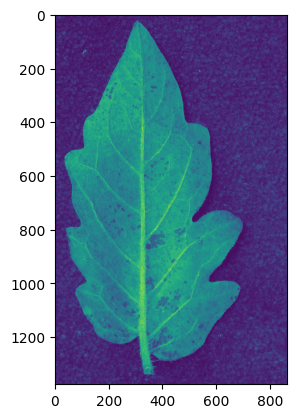

In [6]:

# Load images
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train"
img_size = (1376, 864)
images_kaggle = load_images(image_dir, img_size)

print(f"Loaded {len(images_kaggle)} images")
print(f"Image shape: {images_kaggle[0].shape}")

# Display an image
plt.imshow(images_kaggle[16])
plt.show()

In [7]:

"""# Define an ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Select an image
x = np.expand_dims(images_kaggle[16], axis=0)  # Add batch dimension

# Generate augmented images
augmented_images = datagen.flow(x, batch_size=1)

# Display a few augmented images
plt.figure(figsize=(30, 10))
for i in range(5):
    batch = next(augmented_images)
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0])  # Since rescale=1./255, no need for astype('uint8')
    plt.axis('off')
plt.show()"""

"# Define an ImageDataGenerator with augmentations\ndatagen = ImageDataGenerator(\n    rescale=1./255,  # Normalize images to [0, 1]\n    rotation_range=40,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n)\n\n# Select an image\nx = np.expand_dims(images_kaggle[16], axis=0)  # Add batch dimension\n\n# Generate augmented images\naugmented_images = datagen.flow(x, batch_size=1)\n\n# Display a few augmented images\nplt.figure(figsize=(30, 10))\nfor i in range(5):\n    batch = next(augmented_images)\n    plt.subplot(1, 5, i+1)\n    plt.imshow(batch[0])  # Since rescale=1./255, no need for astype('uint8')\n    plt.axis('off')\nplt.show()"

(17, 1376, 864, 1)


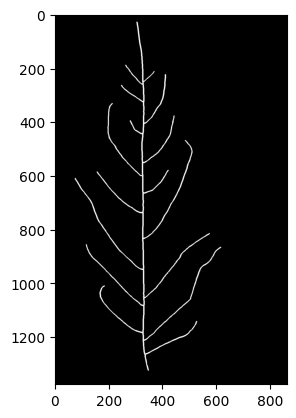

In [8]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Set image size to 1200x800
HEIGHT = 1400
WIDTH = 875

# Read mask annotations from the CSV file
mask_read = pd.read_csv("drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train.csv")
mask = mask_read['annotation']

# Run-length decoding function
def rl_decode(enc):
    parts = [int(s) for s in enc.split(' ')]
    dec = list()
    for i in range(0, len(parts), 2):
        cnt = parts[i]
        val = parts[i+1]
        dec += cnt * [val]
    return np.array(dec, dtype=np.uint8).reshape((HEIGHT, WIDTH))

# List to store decoded masks
decoded_masks = []

# Decode and resize each mask
for item in mask:
    np_mask = rl_decode(item)

    # Resize to 1200x800 size
    np_mask_resize = cv2.resize(np_mask, (864, 1376))  # Width, Height order
    np_mask_resize = np_mask_resize[:,:]  # You can trim or manipulate the mask if necessary
    decoded_masks.append(np_mask_resize)

# Convert to numpy array and expand dimensions for model input
decoded_masks = np.array(decoded_masks, dtype=np.float32)
decoded_masks = np.expand_dims(decoded_masks, axis=-1)

# Print the shape of the decoded masks
print(decoded_masks.shape)

# Show a sample decoded mask
plt.imshow(decoded_masks[16].squeeze(), cmap='gray')
plt.show()

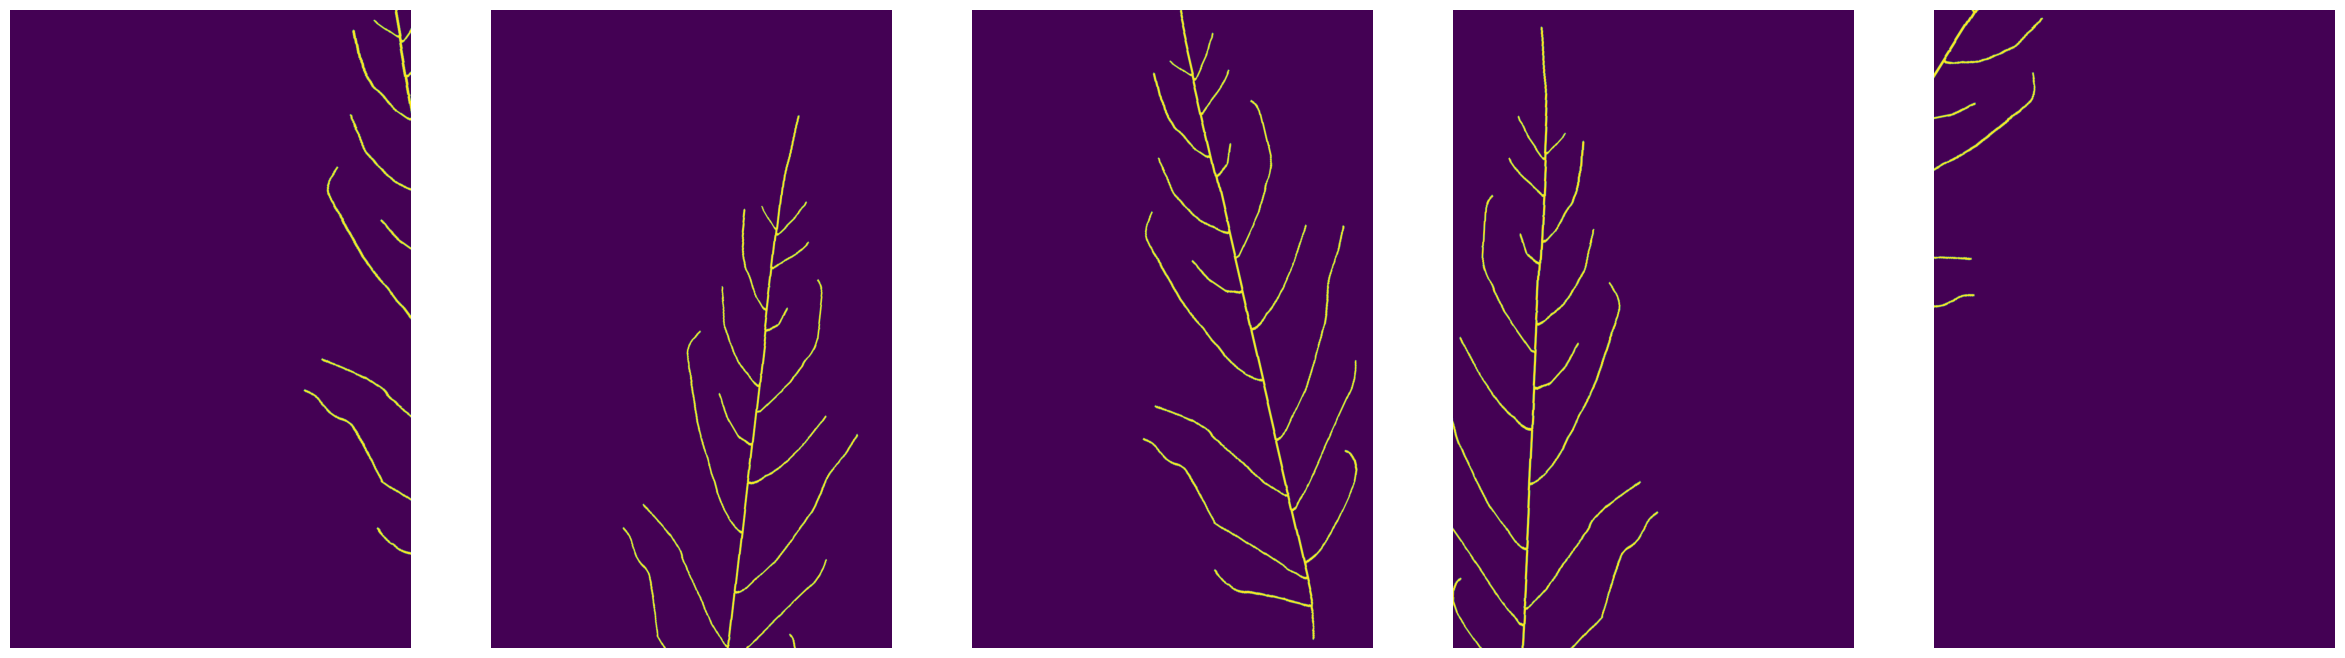

In [9]:

# Define an ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Select an image
x = np.expand_dims(decoded_masks[16], axis=0)  # Add batch dimension

# Generate augmented images
augmented_images = datagen.flow(x, batch_size=1)

# Display a few augmented images
plt.figure(figsize=(30, 10))
for i in range(5):
    batch = next(augmented_images)
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0])  # Since rescale=1./255, no need for astype('uint8')
    plt.axis('off')
plt.show()

Split Train - Validate Test

In [10]:
# Step 1: Split data into training (70%) and temp (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(images_kaggle, decoded_masks, test_size=0.3, random_state=42)

# Step 2: Split temp into validation (50%) and test (50%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



Unet Model

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Convolutional Block
def conv_block(x, kernelsize, filters, dropout, batchnorm=True):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

# U-Net Model
def unetmodel(input_shape, dropout=0.2, batchnorm=True):
    filters = [64, 128, 256, 512, 1024]  # Filter sizes for each convolutional layer
    kernelsize = 3
    upsample_size = 2  # Upsampling size

    inputs = layers.Input(input_shape)

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(dn_1)

    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(dn_2)

    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2, 2))(dn_3)

    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2, 2))(dn_4)

    # Removed dn_5 and pool_5
    # bottleneck = conv_block(pool_5, kernelsize, filters[5], dropout, batchnorm)
    bottleneck = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)  # Changed to pool_4

    # Upsampling layers
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size))(bottleneck)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)

    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size))(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)

    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size))(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)

    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size))(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)

    # Final output layer
    conv_final = layers.Conv2D(1, kernel_size=(1, 1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Define the input shape and create the U-Net model
input_shape = (1280, 800, 3)  # Input shape (height, width, channels)
modelunet = unetmodel(input_shape)

# Compile the model

modelunet.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, IoU_coef])


# Display model summary
modelunet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1280, 800, 3)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1280, 800, 64)  │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1280, 800, 64)  │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1280, 800, 64)  │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280, 800, 64)  │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1280, 800, 64)  │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1280, 800, 64)  │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1280, 800, 64)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 640, 400, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 640, 400, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 640, 400, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 640, 400, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 640, 400, 128)  │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 640, 400, 128)  │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 640, 400, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 640, 400, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 320, 200, 128)  │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)       

 Total params: 31,402,501 (119.79 MB)

 Trainable params: 31,390,723 (119.75 MB)

 Non-trainable params: 11,778 (46.01 KB)

In [12]:
#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        #conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)

    #skip connection
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    #shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])
    respath_final = layers.Activation("relu")(respath)
    return respath_final


#Res-UNET
def residualunet(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers
    dn_conv1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    dn_pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv1)

    dn_conv2 = res_conv_block(dn_pool1, kernelsize, filters[1], dropout, batchnorm)
    dn_pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv2)

    dn_conv3 = res_conv_block(dn_pool2, kernelsize, filters[2], dropout, batchnorm)
    dn_pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv3)

    dn_conv4 = res_conv_block(dn_pool3, kernelsize, filters[3], dropout, batchnorm)
    dn_pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv4)

    dn_conv5 = res_conv_block(dn_pool4, kernelsize, filters[4], dropout, batchnorm)

    # upsampling layers
    up_conv6 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_conv5)
    up_conv6 = layers.concatenate([up_conv6, dn_conv4], axis=3)
    up_conv6 = res_conv_block(up_conv6, kernelsize, filters[3], dropout, batchnorm)

    up_conv7 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv6)
    up_conv7 = layers.concatenate([up_conv7, dn_conv3], axis=3)
    up_conv7 = res_conv_block(up_conv7, kernelsize, filters[2], dropout, batchnorm)

    up_conv8 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv7)
    up_conv8 = layers.concatenate([up_conv8, dn_conv2], axis=3)
    up_conv8 = res_conv_block(up_conv8, kernelsize, filters[1], dropout, batchnorm)

    up_conv9 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv8)
    up_conv9 = layers.concatenate([up_conv9, dn_conv1], axis=3)
    up_conv9 = res_conv_block(up_conv9, kernelsize, filters[0], dropout, batchnorm)


    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv9)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

input_shape = (1376, 864, 1)
residualunet = residualunet(input_shape)

residualunet.compile(optimizer = Adam(learning_rate=0.001), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
residualunet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1376, 864, 1)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 1376, 864, 16)  │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 1376, 864, 16)  │             64 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 1376, 864, 16)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 1376, 864, 16)  │              0 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 1376, 864, 16)  │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 1376, 864, 16)  │             64 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 1376, 864, 16)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 688, 432, 16)   │              0 │ activation_20[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 688, 432, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 688, 432, 32)   │            128 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 688, 432, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 688, 432, 32)   │          9,248 │ activation_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 688, 432, 32)   │            544 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 688, 432, 32)   │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,080,629 (7.94 MB)

 Trainable params: 2,076,243 (7.92 MB)

 Non-trainable params: 4,386 (17.13 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1376, 864, 1)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 1376, 864, 16)  │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 1376, 864, 16)  │             64 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 1376, 864, 16)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 1376, 864, 16)  │              0 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 1376, 864, 16)  │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 1376, 864, 16)  │             64 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 1376, 864, 16)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 688, 432, 16)   │              0 │ activation_20[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 688, 432, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 688, 432, 32)   │            128 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 688, 432, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 688, 432, 32)   │          9,248 │ activation_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 688, 432, 32)   │            544 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 688, 432, 32)   │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,080,629 (7.94 MB)

 Trainable params: 2,076,243 (7.92 MB)

 Non-trainable params: 4,386 (17.13 KB)

In [13]:
# Step 1: Split data into training (70%) and temp (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(images_kaggle, decoded_masks, test_size=0.1, random_state=42)
1
# Step 2: Split temp into validation (50%) and test (50%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(15, 1376, 864)
(1, 1376, 864)
(1, 1376, 864)


In [14]:
class StopAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, stop_epoch):
        super().__init__()
        self.stop_epoch = stop_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.stop_epoch:
            print(f"\nStopping training at epoch {self.stop_epoch}")
            self.model.stop_training = True

In [15]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.weights.h5',  # Save path
    save_best_only=True,            # Save the model at every epoch
    save_weights_only=True           # Save weights instead of the full model
)
stop_epoch = 100
print(images_kaggle.shape)
print(decoded_masks.shape)

#history= model.fit(image_dataset,decoded_masks,epochs=50,batch_size=2, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)])
Modelfit= residualunet.fit(X_train,y_train,epochs=100,batch_size=2, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)],validation_data=(X_val, y_val))


(17, 1376, 864)
(17, 1376, 864, 1)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_79']
Received: inputs=Tensor(shape=(None, 1376, 864))
  warnings.warn(msg)


8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.5282 - io_u_coef: 0.0221 - loss: -0.0220 - val_accuracy: 0.0232 - val_io_u_coef: 0.0214 - val_loss: -0.0214
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 385ms/step - accuracy: 0.6527 - io_u_coef: 0.0309 - loss: -0.0308 - val_accuracy: 0.0225 - val_io_u_coef: 0.0214 - val_loss: -0.0214
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 390ms/step - accuracy: 0.7172 - io_u_coef: 0.0321 - loss: -0.0320 - val_accuracy: 0.0225 - val_io_u_coef: 0.0214 - val_loss: -0.0214
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.7581 - io_u_coef: 0.0328 - loss: -0.0328 - val_accuracy: 0.2320 - val_io_u_coef: 0.0262 - val_loss: -0.0262
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.7610 - io_u_coef: 0.0335 - loss: -0.0334 - val_accuracy: 0.4721 - val_io_u_coef: 0.0324 - val_loss: -0.0324
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step - accuracy: 0.7885 - io_u_coef: 0.0343 - loss: -0.0343 - val_accuracy: 0.6028 - val_io_u_coef: 0

In [16]:
# Save the entire model (architecture, weights, optimizer)
modelunet.save('Resnet_model_7.h5')  # You can use any name for the file

Test on Single point

Test Images Shape: (1, 1376, 864)
Ground Truth Masks Shape: (1, 1376, 864, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_79']
Received: inputs=Tensor(shape=(1, 1376, 864))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction Shape: (1376, 864, 1)


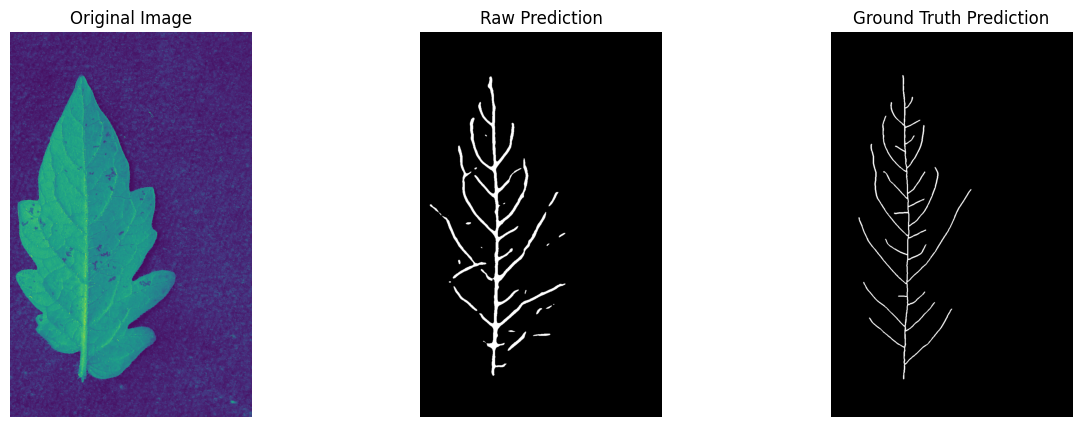

In [17]:
image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train"
img_size = (1280, 800)  # Input size for U-Net
images_test = load_images(image_dir, img_size)

images_test =X_test


print("Test Images Shape:", images_test.shape)  # Shape should be (n_images, 1280, 800, 3)

# Load the corresponding ground truth mask (Y_TRAIN) -- assuming you have the file path or access to it
# Here, we will assume that `Y_TRAIN` is already loaded and processed accordingly.
# For example, you might load `Y_TRAIN` from another directory or as a numpy array.

# Example of loading Y_TRAIN (ground truth mask)
#mask_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train_masks"  # Directory where ground truth masks are stored
#ground_truth_masks = load_images(mask_dir, img_size)  # This assumes masks are stored similarly to images

ground_truth_masks = y_test

print("Ground Truth Masks Shape:", ground_truth_masks.shape)  # Shape should be (n_images, 1280, 800, 1) for masks

# Model prediction
predictions = residualunet.predict(images_test)

print("Prediction Shape:", predictions[0].shape)  # Shape should be (1, 875, 1400, 3)

# If your model outputs a 3-channel prediction, we'll select the first channel (or whichever channel corresponds to your mask)
reshaped_predictions = predictions[0][:, :, 0]  # Remove the batch and channel dimensions

# Threshold the prediction to binary (0 or 1)
thresholded_predictions = (reshaped_predictions > 0.97).astype(np.uint8)

# Compare with ground truth mask (Y_TRAIN)
ground_truth_mask = ground_truth_masks[0][:, :, 0]  # Assuming the ground truth mask has the same shape, and only one channel

# Plotting the original image, the predicted mask, and the thresholded mask
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(images_test[0])  # Display original image (RGB)
plt.title('Original Image')
plt.axis('off')  # Hide axis

# Predicted Mask (Continuous values, without thresholding)
plt.subplot(1, 3, 2)
plt.imshow(thresholded_predictions, cmap='gray')  # Display raw prediction (continuous values)
plt.title('Raw Prediction')
plt.axis('off')

# Thresholded Mask (Binary mask)
plt.subplot(1, 3, 3)
plt.imshow(ground_truth_mask, cmap='gray')  # Display thresholded prediction (binary mask)
plt.title('Ground Truth Prediction')
plt.axis('off')

plt.show()

# Optionally save the thresholded predictions to a file
np.savetxt('predictions.txt', thresholded_predictions)

# Optionally, save the comparison between predictions and ground truth mask
np.savetxt('ground_truth_mask.txt', ground_truth_mask)

Creating Testing Data Evalautions

In [18]:
def run_length_encode(mask):
    # Flatten the 2D mask into a 1D array
    flat_mask = mask.flatten()
    # Initialize the result list to store the RLE encoding
    rle = []
    # Initialize the first character of the string and the count
    prev_char = flat_mask[0]
    count = 1
    # Iterate through the flattened mask starting from the second character
    for char in flat_mask[1:]:
        if char == prev_char:
            # If the character is the same as the previous one, increment the count
            count += 1
        else:
            # If the character changes, append the previous character's count and value to the result
            rle.append(count)
            rle.append(prev_char)
            # Reset the count for the new character
            prev_char = char
            count = 1
    # Append the last character's count and value
    rle.append(count)
    rle.append(prev_char)
    # Return the RLE encoded result as a space-separated string
    return ' '.join(map(str, rle))

In [21]:
# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(img_path, img_size=(1376, 864)):
    img = load_img(img_path, target_size=img_size)  # Resize to the input size of the model
    img = img_to_array(img)  # Convert to a numpy array
    img = img[:,:,0]
    #img = img / 255.0  # Normalize to the range [0, 1] if needed
    return np.expand_dims(img, axis=0)  # Add batch dimension

Predict and Create File

In [22]:

# Create the submission data list
submission_data = []

test_folder = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/test"
# Iterate through all images in the test folder
for image_name in os.listdir(test_folder):
    if image_name.endswith(('.jpg', '.png')):  # Only process image files
        img_path = os.path.join(test_folder, image_name)

        # Preprocess the image (resize, normalize)
        image_dataset_testimage = preprocess_image(img_path)  # No need for load_images

        # Predict the mask using the model
        mask_prediction = residualunet.predict(image_dataset_testimage)  # Model prediction
        mask = mask_prediction[0, :, :, 0]  # Extract the first channel (assuming grayscale mask)

        # Resize the mask to match the test output size (e.g., 875 x 1400)
        mask_resized = cv2.resize(mask, (875, 1400))

        # Threshold the mask to binary (0 or 1)
        mask_binary = (mask_resized > 0.97).astype(np.uint8)

        # Apply RLE encoding to the binary mask
        rle_encoded = run_length_encode(mask_binary)

        # Append the result to the submission data list
        image_id = image_name.split('.')[0]  # Extract the image ID without file extension
        submission_data.append([image_id, rle_encoded])

# Create a DataFrame for the submission
submission_df = pd.DataFrame(submission_data, columns=['id', 'annotation'])

# Save the DataFrame as a CSV file for submission
submission_df.to_csv('submissionNewSimpleResNet2000.csv', index=False)

print("Submission file created successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Submission file created successfully!
